# Send and receive a pulse 

This notebook is based on the [send-receive-pulse demo](../qick_demos/00_Send_receive_pulse.ipynb).

In [1]:
# You should be on the ml branch of https://github.com/GiuseppeDiGuglielmo/qick
!git branch

  main
* ml-dev
  ml-dev-origin


In [2]:
!echo -n "git rev:  "; git rev-parse --short HEAD
!echo -n "git date: "; git log -1 --format=%cd

git rev:  28e9a41
git date: Fri May 17 23:19:33 2024 -0500


In [3]:
import subprocess
branch_name = subprocess.getoutput("git rev-parse --abbrev-ref HEAD")
print(branch_name)

ml-dev


In [4]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Current directory
!pwd

/home/xilinx/jupyter_notebooks/qick_dev/qick_ml


In [6]:
# List custom bitstreams
!ls -l 216/$branch_name/'00000000'

total 104776
drwxrwxr-x 2 xilinx xilinx     4096 May 19 13:07 OLD
-rw-rw-r-- 1 xilinx xilinx 34437473 May 19 20:54 qick_216_nn_w100.bit
-rw-rw-r-- 1 xilinx xilinx  1322232 May 19 20:54 qick_216_nn_w100.hwh
-rw-rw-r-- 1 xilinx xilinx 34437473 May 19 20:10 qick_216_nn_w200.bit
-rw-rw-r-- 1 xilinx xilinx  1322232 May 19 20:10 qick_216_nn_w200.hwh
-rw-rw-r-- 1 xilinx xilinx 34437473 May 19 14:42 qick_216_nn_w400.bit
-rw-rw-r-- 1 xilinx xilinx  1322232 May 19 14:42 qick_216_nn_w400.hwh


In [7]:
!ls -l 216/$branch_name/'20240501'

total 4
drwxrwxr-x 2 xilinx xilinx 4096 May 19 13:07 OLD


In [8]:
# Choose custom bistreams

DATASET_DATE = '00000000'
#DATASET_DATE = '20240501'

# QICK
#CUSTOM_BIT = '216/{}/qick_216_orig.bit'.format(branch_name)
#HAS_NN = 0

# QICK + ILAs + syn/imp optimizations
# CUSTOM_BIT = '216/ml-dev/qick_216_ila.bit'
# HAS_NN = 0

# QICK + NN + syn/imp optimizations
CUSTOM_BIT = '216/{}/{}/qick_216_nn_w400.bit'.format(branch_name, DATASET_DATE)
HAS_NN = 1

# Configure channels
GEN_CH = 0
RO_CH = 0

In [9]:
# Load bitstream with custom overlay
if not 'CUSTOM_BIT' in locals():
    soc = QickSoc()
else:
    import os
    # Normalize path
    CUSTOM_BIT_FULL_PATH = os.path.normpath(os.getcwd() + '/' + CUSTOM_BIT)
    print('Custom bitsream:', CUSTOM_BIT_FULL_PATH)
    
    soc = QickSoc(bitfile=CUSTOM_BIT_FULL_PATH)

soccfg = soc
print(soccfg)

Custom bitsream: /home/xilinx/jupyter_notebooks/qick_dev/qick_ml/216/ml-dev/00000000/qick_216_nn_w400.bit

QICK configuration:

	Board: ZCU216

	Software version: 0.2.249
	Firmware timestamp: Sun May 19 11:47:12 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3

	2 readout channels:
	0:	axis_readout_v2 - controlled by PYNQ
		fs=2457.600 MHz, fabric=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 1024 decimated (3.333 us)
		triggered by output 0, pin 8, feedback to tProc input -1
		ADC tile 2, blk 0 is 0_226, on JHC7
	1:	axis_readout_v2 - controlled by PYNQ
		fs=2457.600 M

In [10]:
print('Loaded bitstream:', soccfg.bitfile_name)

Loaded bitstream: /home/xilinx/jupyter_notebooks/qick_dev/qick_ml/216/ml-dev/00000000/qick_216_nn_w400.bit


### Hardware Configuration

<!--generator channel 6 : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0-->

In [11]:
print('Generator channel: {}'.format(GEN_CH))
print('Readout channel  : {}'.format(RO_CH))

Generator channel: 0
Readout channel  : 0


In [12]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
        # equivalent to the following:
#         self.trigger(adcs=self.ro_chs,
#                      pins=[0], 
#                      adc_trig_offset=self.cfg["adc_trig_offset"])
#         self.pulse(ch=self.cfg["res_ch"])
#         self.wait_all()
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

### NN scaler setup

### Load an excited state

In [13]:
config={"res_ch": GEN_CH, #6, # --Fixed
        "ro_chs": [RO_CH], # --Fixed
        "reps": 1, # --Fixed
        "relax_delay": 1.0, # --us
        "res_phase": 0, # --degrees
        "pulse_style": "const", # --Fixed

        "length":400, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":770, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs": 3
        # Try varying soft_avgs from 1 to 200 averages        
        
       }

In [14]:
#########################################################
# If you are running Vivado ILA, it is time to arm them #
#########################################################

In [15]:
from ctypes import *

def to_float(w):
    """
    Convert a 32b memory word to a floating-point number using ctypes.
    
    Args:
        w (int): The 32b word to convert.
        
    Returns:
        float: The converted floating-point number.
    """
    cp = pointer(c_int(w))
    fp = cast(cp, POINTER(c_float))
    return fp.contents.value

from pynq import MMIO

def reset_classifier(deep_reset = False, index_lo = 0, index_hi = 0):
    """
    Reset the classifier. Optionally perform a deep reset.
    
    Args:
        deep_reset (bool): If True, perform a deep reset by setting specific memory locations to zero. Default is False.
        index_lo (int): The lower index for the deep reset range. Default is 0.
        index_hi (int): The upper index for the deep reset range. Default is 0.
    """
    RESET_HI = 255
    RESET_LO = 0
    # Access the MMIO interface of the classifier
    mmio_nn = MMIO(soccfg.NN_0.mmio.base_addr, soccfg.NN_0.mmio.length)
    # This sends a "reset pulse" to the classifier
    mmio_nn.write(soccfg.NN_0.register_map.out_reset.address, RESET_HI)
    mmio_nn.write(soccfg.NN_0.register_map.out_reset.address, RESET_LO)
    if deep_reset:
        # Perform a deep reset by setting specific memory locations to zero
        # Warning: This may run for a long time; use only for debugging
        print('WARNING: Deep reset may run for some time... use only for debugging')
        entry_count = ((index_hi - index_lo) + 1) * 2
        for i in range(entry_count):
            soccfg.axi_blk_bram_ctrl_0.mmio.array[i] = 0

def configure_classifier(window_size, window_offset, scaling_factor, trigger_delay, debug = False):
    """
    Configure the classifier with the specified parameters.
    
    Args:
        window_size (int): The size of the window for classification.
        window_offset (int): The offset of the window for classification.
        scaling_factor (int): The scaling factor for classification.
        trigger_delay (int): The delay for triggering classification.
        debug (bool): If True, print debug information. Default is False.
    """
    if debug:
        # Print debug information about the classifier configuration
        print('INFO: classifier MMIO')
        print('INFO:   - base address:   @{:08x}'.format(soccfg.NN_0.mmio.base_addr))
        print('INFO:   - window_size:    @{} = {}'.format('??', window_size))
        print('INFO:   - window_offset:  @{:04x} = {}'.format(soccfg.NN_0.register_map.window_offset.address, window_offset))
        print('INFO:   - scaling_factor: @{:04x} = {}'.format(soccfg.NN_0.register_map.scaling_factor.address, scaling_factor))
        print('INFO:   - trigger_delay:  @{:04x} = {}'.format(soccfg.NN_0.register_map.trigger_delay.address, trigger_delay))
    # Access the MMIO interface of the classifier and configure it
    mmio_nn = MMIO(soccfg.NN_0.mmio.base_addr, soccfg.NN_0.mmio.length)
    mmio_nn.write(soccfg.NN_0.register_map.window_offset.address, window_offset)
    mmio_nn.write(soccfg.NN_0.register_map.scaling_factor.address, scaling_factor)
    mmio_nn.write(soccfg.NN_0.register_map.trigger_delay.address, trigger_delay)

def get_classifier_prediction_count():
    """
    Get how many predictions (pulses) have run through the classifier. This is 0 at the very beginning or if you reset the classifier.
    
    Returns:
        int: The number of predictions made by the classifier.
    """
    # Access the MMIO interface of the classifier
    mmio_nn = MMIO(soccfg.NN_0.mmio.base_addr, soccfg.NN_0.mmio.length)
    # Read and return the prediction count
    prediction_count = mmio_nn.read(soccfg.NN_0.register_map.out_offset.address)
    return prediction_count

def get_classifier_prediction(index = 0):
    """
    Get the classifier prediction for a specific index of the buffer.
    
    Args:
        index (int): The index of the prediction to retrieve. Default is 0.
        
    Returns:
        tuple: A tuple containing the ground state logit and the excited state logit.
    """
    WORD_SIZE_BYTE = 4
    WORD_COUNT_PER_PREDICTION = 2
    # Access the MMIO interface of the BRAM
    mmio_bram = MMIO(soccfg.axi_blk_bram_ctrl_0.base_address, soccfg.axi_blk_bram_ctrl_0.size)
    # Read the logits for the ground state and excited state
    ground_state_logit = mmio_bram.read(index * WORD_COUNT_PER_PREDICTION * WORD_SIZE_BYTE + 0)
    excited_state_logit = mmio_bram.read(index * WORD_COUNT_PER_PREDICTION * WORD_SIZE_BYTE + WORD_SIZE_BYTE)
    return ground_state_logit, excited_state_logit

def get_classifier_predictions(index_lo = 0, index_hi = 0):
    """
    Get a range of classifier predictions from the buffer.
    
    Args:
        index_lo (int): The lower index of the range of predictions to retrieve. Default is 0.
        index_hi (int): The upper index of the range of predictions to retrieve. Default is 0.
        
    Returns:
        list: A list of tuples, each containing the ground state logit and the excited state logit.
    """
    WORD_SIZE_BYTE = 4
    WORD_COUNT_PER_PREDICTION = 2
    # Access the MMIO interface of the BRAM
    mmio_bram = MMIO(soccfg.axi_blk_bram_ctrl_0.base_address, soccfg.axi_blk_bram_ctrl_0.size)
    # TODO: You can read the whole memory area rather than one element at a time and append
    predictions = []
    for index in range(index_lo, index_hi + 1):
        ground_state_logit = mmio_bram.read(index * WORD_COUNT_PER_PREDICTION * WORD_SIZE_BYTE + 0)
        excited_state_logit = mmio_bram.read(index * WORD_COUNT_PER_PREDICTION * WORD_SIZE_BYTE + WORD_SIZE_BYTE)
        predictions.append([ground_state_logit, excited_state_logit])
    return predictions

def print_classifier_buffer(index_lo, index_hi):
    """
    Print the classifier buffer for a range of indices.
    
    Args:
        index_lo (int): The lower index of the range to print.
        index_hi (int): The upper index of the range to print.
    """
    # Get the prediction count and buffer size
    prediction_count = get_classifier_prediction_count()
    buffer_size = len(soccfg.axi_blk_bram_ctrl_0.mmio.array)
    print('INFO: prediction count: {:6}'.format(prediction_count))
    print('INFO: buffer size     : {:6}'.format(buffer_size))
    print('INFO:')
    for i in range(index_lo, index_hi + 1):
        # Get the logits for each prediction and print them
        ground_state_logit, excited_state_logit = get_classifier_prediction(i)
        print('INFO: [{:5d}] {:08x} ({}) {}'.format(i, ground_state_logit, to_float(ground_state_logit), '<<<' if prediction_count == i else ''))
        print('INFO: [{:5d}] {:08x} ({}) {}'.format(i, excited_state_logit, to_float(excited_state_logit), '<<<' if prediction_count == i else ''))

In [16]:
%%time
if HAS_NN:
    WINDOW_SIZE = 400
    WINDOW_OFFSET = 150
    SCALING_FACTOR = 1
    TRIGGER_DELAY = 0
    
    # Reset the classifier in deep mode (first 16 elements of the buffer are set to 0)
    reset_classifier(deep_reset = True, index_lo = 0, index_hi = 15)
    
    # The NN IP ignores the WINDOW_SIZE for now
    configure_classifier(WINDOW_SIZE, WINDOW_OFFSET, SCALING_FACTOR, TRIGGER_DELAY, debug=True)

INFO: classifier MMIO
INFO:   - base address:   @a0020000
INFO:   - window_size:    @?? = 400
INFO:   - window_offset:  @0010 = 150
INFO:   - scaling_factor: @0018 = 1
INFO:   - trigger_delay:  @0020 = 0
CPU times: user 1.63 s, sys: 49.8 ms, total: 1.68 s
Wall time: 1.64 s


In [17]:
if HAS_NN:
    print_classifier_buffer(index_lo=0, index_hi=7)

INFO: prediction count:      0
INFO: buffer size     :  32768
INFO:
INFO: [    0] 00000000 (0.0) <<<
INFO: [    0] 00000000 (0.0) <<<
INFO: [    1] 00000000 (0.0) 
INFO: [    1] 00000000 (0.0) 
INFO: [    2] 00000000 (0.0) 
INFO: [    2] 00000000 (0.0) 
INFO: [    3] 00000000 (0.0) 
INFO: [    3] 00000000 (0.0) 
INFO: [    4] 00000000 (0.0) 
INFO: [    4] 00000000 (0.0) 
INFO: [    5] 00000000 (0.0) 
INFO: [    5] 00000000 (0.0) 
INFO: [    6] 00000000 (0.0) 
INFO: [    6] 00000000 (0.0) 
INFO: [    7] 00000000 (0.0) 
INFO: [    7] 00000000 (0.0) 


  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 355 ms, sys: 10.9 ms, total: 366 ms
Wall time: 283 ms


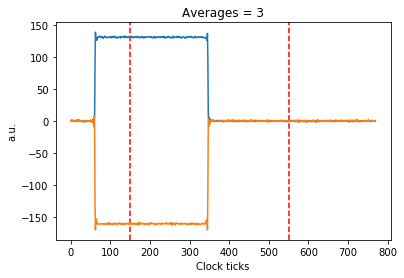

In [18]:
%%time
for i in range(1):
    prog = LoopbackProgram(soccfg, config)
    
    iq_list = prog.acquire_decimated(soc, progress=True)
    
    
    ###########################################################
    axvline(WINDOW_OFFSET, ls = '--', color = 'red')
    axvline(WINDOW_OFFSET+WINDOW_SIZE, ls = '--', color = 'red')
    ###########################################################
    
    # Plot results.
    for ii, iq in enumerate(iq_list):
        plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]), color='C0')
        plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]), color='C1')
        #plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
        plt.ylabel("a.u.")
        plt.xlabel("Clock ticks")
        plt.title("Averages = " + str(config["soft_avgs"]))
        #plt.legend()
        #plt.show()
    #plt.savefig("images/send_receive_pulse_const.png", dpi=350)
    np.set_printoptions(threshold=np.inf)
    #print([int(element) for pair in zip(*iq_list[0]) for element in pair])
    #import time
    #time.sleep(1)

In [19]:
import struct
def float_to_hex32(f):
    return format(struct.unpack('!I', struct.pack('!f', f))[0], '08x')

def int_to_twos_complement_hex32(n):
    # If the number is negative, get its two's complement
    if n < 0:
        n = (1 << 32) + n  # "Wrap around" to get 32-bit two's complement
    return format(n, '08x')

# Save trace.
iq = iq_list[0]

# Shows I and Q sequence
iq_sequence = [list(item) for item in zip(*iq)]
iq_sequence = [int(item) for sublist in iq_sequence for item in sublist]

# Float value as hex
#hex_iq_sequence_flt = [float_to_hex32(num) for num in iq_sequence]

# Float -> Int value as hex
#hex_iq_sequence_dec = [int_to_twos_complement_hex32(int(i)) for i in iq_sequence]

# print('Sequence length:', len(iq_sequence))
# print('I (lo, data[15:0])')
# print(iq[0])
# print('Q (hi, data[31:16])')
# print(iq[1])

# print(iq_sequence)

#print(hex_iq_sequence_flt)
#print(hex_iq_sequence_dec)

#for i in range(0,len(iq_sequence),2):
#    print("I {:4.0f} {} {}".format(iq_sequence[i], hex_iq_sequence_flt[i], hex_iq_sequence_dec[i]))
#    print("Q {:4.0f} {} {}".format(iq_sequence[i+1], hex_iq_sequence_flt[i+1], hex_iq_sequence_dec[i+1]))

In [20]:
#print(iq_sequence[285*2:(285+100)*2])
print(iq_sequence)

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, -1, 0, -1, -1, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, -1, 0, 0, 0, 0, 0, 2, -2, 2, -2, 0, 0, 6, -8, -5, 7, 12, -19, 97, -130, 139, -170, 126, -153, 129, -160, 129, -159, 127, -157, 130, -161, 131, -161, 131, -161, 131, -161, 132, -161, 132, -161, 133, -161, 131, -161, 131, -161, 131, -161, 131, -161, 131, -161, 132, -161, 131, -160, 129, -161, 130, -161, 131, -161, 131, -161, 132, -161, 133, -161, 131, -161, 130, -162, 130, -162, 130, -160, 131, -160, 131, -161, 130, -160, 130, -161, 131, -160, 131, -159, 131, -161, 131, -160, 131, -160, 131, -162, 132, -161, 131, -160, 130, -162, 132, -161, 132, -160, 132, -161, 132, -162, 131, -161, 130, -160, 132, -161, 132, -160, 131, -160, 131, -160, 130, -161, 129, -162, 130, -162, 13

In [21]:
#
# ATTENTION: if the cell fails, please make sure that
#            the base_address matches the associated
#            value in the address editor of the Vivado
#            project.
# 
if HAS_NN:
    for i in range(1):
        ground_state_logit, excited_state_logit = get_classifier_prediction(i)

        if (to_float(ground_state_logit) > to_float(excited_state_logit)):
            print("Prediction: ground state")
        else:
            print("Prediction: excited state")
        print('Logit values as int: [', ground_state_logit, ',', excited_state_logit, ']')
        print('Logit values as hex: [', hex(ground_state_logit), ',', hex(excited_state_logit), ']')
        print('Logit values as flt: [', to_float(ground_state_logit), ',', to_float(excited_state_logit), ']')
else:
    print('No NN in this bitstream!')

Prediction: ground state
Logit values as int: [ 1064927232 , 3213574144 ]
Logit values as hex: [ 0x3f798000 , 0xbf8b4000 ]
Logit values as flt: [ 0.974609375 , -1.087890625 ]


In [22]:
if HAS_NN:
    print_classifier_buffer(index_lo=0, index_hi=7)

INFO: prediction count:      3
INFO: buffer size     :  32768
INFO:
INFO: [    0] 3f798000 (0.974609375) 
INFO: [    0] bf8b4000 (-1.087890625) 
INFO: [    1] 3f7a0000 (0.9765625) 
INFO: [    1] bf8c0000 (-1.09375) 
INFO: [    2] 3f784000 (0.9697265625) 
INFO: [    2] bf8b6000 (-1.0888671875) 
INFO: [    3] 00000000 (0.0) <<<
INFO: [    3] 00000000 (0.0) <<<
INFO: [    4] 00000000 (0.0) 
INFO: [    4] 00000000 (0.0) 
INFO: [    5] 00000000 (0.0) 
INFO: [    5] 00000000 (0.0) 
INFO: [    6] 00000000 (0.0) 
INFO: [    6] 00000000 (0.0) 
INFO: [    7] 00000000 (0.0) 
INFO: [    7] 00000000 (0.0) 


In [23]:
if HAS_NN:
    reset_classifier(deep_reset=True, index_hi=7)

In [24]:
if HAS_NN:
    print_classifier_buffer(index_lo=0, index_hi=7)

INFO: prediction count:      0
INFO: buffer size     :  32768
INFO:
INFO: [    0] 00000000 (0.0) <<<
INFO: [    0] 00000000 (0.0) <<<
INFO: [    1] 00000000 (0.0) 
INFO: [    1] 00000000 (0.0) 
INFO: [    2] 00000000 (0.0) 
INFO: [    2] 00000000 (0.0) 
INFO: [    3] 00000000 (0.0) 
INFO: [    3] 00000000 (0.0) 
INFO: [    4] 00000000 (0.0) 
INFO: [    4] 00000000 (0.0) 
INFO: [    5] 00000000 (0.0) 
INFO: [    5] 00000000 (0.0) 
INFO: [    6] 00000000 (0.0) 
INFO: [    6] 00000000 (0.0) 
INFO: [    7] 00000000 (0.0) 
INFO: [    7] 00000000 (0.0) 


In [25]:
# if HAS_NN:
#     print('Readout count: {}'.format(get_classifier_prediction_count()))